In [1]:
%matplotlib inline

In [2]:
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.decomposition import PCA

In [3]:
import sys
sys.path.insert(0, os.path.abspath('..'))
from milleniumcohort import create_config
config = create_config('../config.yml')

/home/dafne/timeseries/milleniumcohort-acc/python/milleniumcohort/utils.py:147: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel_yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel_yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  conf = yaml.load(f.read())


In [4]:
config.model_path

'/media/sf_VBox_Shared/London/CLSdata500/results/mod_10st_0b_50r_720t_acceleration'

In [9]:
model1_path = os.path.abspath(os.path.join(config.model_path, '../mod_10st_0b_15r_720t_acceleration'))
model2_path = os.path.abspath(os.path.join(config.model_path, '../mod_10st_0b_15r_720t_acceleration_anglex_angley_anglez'))

In [10]:
model1_path

'/media/sf_VBox_Shared/London/CLSdata500/results/mod_10st_0b_15r_720t_acceleration'

In [12]:
conn1 = sqlite3.connect(os.path.join(model1_path, 'milleniumcohort.db'))
model1_times_long = pd.read_sql('Select filename, state, count(*) from data_with_states group by filename, state', conn1)
model1_times = model1_times_long.pivot('filename', 'state')

In [13]:
conn2 = sqlite3.connect(os.path.join(model2_path, 'milleniumcohort.db'))
model2_times_long = pd.read_sql('Select filename, state, count(*) from data_with_states group by filename, state', conn2)
model2_times = model2_times_long.pivot('filename', 'state')

In [14]:
cutoff_times_long = pd.read_sql('Select filename, heuristic, count(*) from data_with_states group by filename, heuristic', conn1)
cutoff_times = cutoff_times_long.pivot('filename', 'heuristic')

In [15]:
conn1.close()
conn2.close()

In [16]:
# Are the filenames the same?
np.all(model1_times.index == model2_times.index)

True

In [17]:
def table_to_X(times, min_hours = 20):
    total_5sec = times.sum(axis=1)
    times_norm = times.divide(total_5sec, axis='index')
    times_norm = times_norm[total_5sec>min_hours*60*12]
    times_norm = times_norm.fillna(0)
    X = times_norm.as_matrix()
    return X

In [18]:
X_cutoff = table_to_X(cutoff_times)
X_model1 = table_to_X(model1_times)
X_model2 = table_to_X(model2_times)

## PCA

In [ ]:
pca_cutoff = PCA(n_components=X_cutoff.shape[1])
pca_cutoff.fit(X_cutoff)

pca_model1 = PCA(n_components=X_model1.shape[1])
pca_model1.fit(X_model1)

pca_model2 = PCA(n_components=X_model2.shape[1])
pca_model2.fit(X_model2)

In [ ]:
total_nr = X_cutoff.shape[1]

plt.plot(np.cumsum(pca_cutoff.explained_variance_ratio_), label='cut-point', marker='o')
plt.plot(np.cumsum(pca_model1.explained_variance_ratio_), label='acceleration', marker='s')
plt.plot(np.cumsum(pca_model2.explained_variance_ratio_), label='acceleration+angles', marker='D')
plt.xlabel('# components')
plt.ylabel('fraction explained variance')
plt.xticks(range(total_nr), range(1, total_nr+1))
plt.legend(loc=4)
plt.savefig(os.path.join(config.image_path, 'pca.png'), dpi=300)
plt.show()

In [ ]:
cumvars = pd.DataFrame({'acceleration': np.cumsum(pca_model1.explained_variance_ratio_),
                        'acceleration+angles': np.cumsum(pca_model2.explained_variance_ratio_),
              'cut-point': np.cumsum(pca_cutoff.explained_variance_ratio_)})
cumvars.index = np.arange(1, 11)
cumvars

## Correlation

In [60]:
def get_pcolorplot(correlations, ax, cmap='coolwarm', vmin=-1, vmax=1, xlabels=None, ylabels=None, values_c=None):
    ax.pcolor(correlations, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_yticks(np.arange(correlations.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(correlations.shape[1]) + 0.5, minor=False)
    if xlabels is None:
        xlabels = range(correlations.shape[0])
    if ylabels is None:
        ylabels2 = range(correlations.shape[1])
    else:
        ylabels2 = ylabels
    if values_c is not None:
        for y in range(correlations.shape[0]):
            for x in range(correlations.shape[1]):
                ax.text(x + 0.5, y + 0.5, '%.2f' % correlations.values[y, x],
                         horizontalalignment='center',
                         verticalalignment='center',
                       fontsize=10,
                       color=values_c)     
    ax.invert_yaxis()
    ax.set_xticklabels(xlabels, minor=False)
    ax.set_yticklabels(ylabels2, minor=False)
    ax.tick_params(length=0)

In [20]:
heuristic_classes = [' 1 - sustained activity',  #1
                     ' 2 - non-bouted inactivity', #2
                     ' 4 - >=30min inactivity', #3 
                     ' 3 - 10-30min inactivity', #4
                     ' 5 - non-bouted LPA', #5
                     ' 7 - >=10min LPA', #6
                     ' 6 - 1-10min LPA', #7
                     ' 8 - non-bouted MVPA', #8
                     '10 - >=10min MVPA', #9
                    ' 9 - 1-10min MVPA' #10
                     ]
get_heuristic = lambda i: heuristic_classes[int(i)-1]

In [21]:
model2_labels_dict = {9: 'A',
    2: 'B',
    0: 'C',
    3: 'D',
    4: 'E',
    6: 'F',
    5: 'G',
    1: 'H',
    7: 'I',
    8: 'J' }
model2_labels = [model2_labels_dict[i] for i in range(10)]

In [22]:
model1_order = [5,
                6,
                8,
                9,
                0,
                7,
                4,
                3,
                2,
                1]
model1_labels_dict = {model1_order[i]: chr(range(ord('A'), ord('Z'))[i]) for i in range(len(model1_order))} 
model1_labels = [model1_labels_dict[i] for i in range(10)]
model1_labels_dict

{0: 'E',
 1: 'J',
 2: 'I',
 3: 'H',
 4: 'G',
 5: 'A',
 6: 'B',
 7: 'F',
 8: 'C',
 9: 'D'}

In [23]:
cor_model1 = np.corrcoef(X_model1.transpose())
cor_model2 = np.corrcoef(X_model2.transpose())
cor_cutoff = np.corrcoef(X_cutoff.transpose())

In [32]:
cor_cutoff_df = pd.DataFrame(cor_cutoff, index=heuristic_classes, columns=heuristic_classes)
cor_cutoff_df = cor_cutoff_df.sort_index(axis=0).sort_index(axis=1)

cor_model1_df = pd.DataFrame(cor_model1, index=model1_labels, columns=model1_labels)
cor_model1_df = cor_model1_df.sort_index(axis=0).sort_index(axis=1)

cor_model2_df = pd.DataFrame(cor_model2, index=model2_labels, columns=model2_labels)
cor_model2_df = cor_model2_df.sort_index(axis=0).sort_index(axis=1)

In [36]:
cor_cutoff_df.values[0,0]

1.0

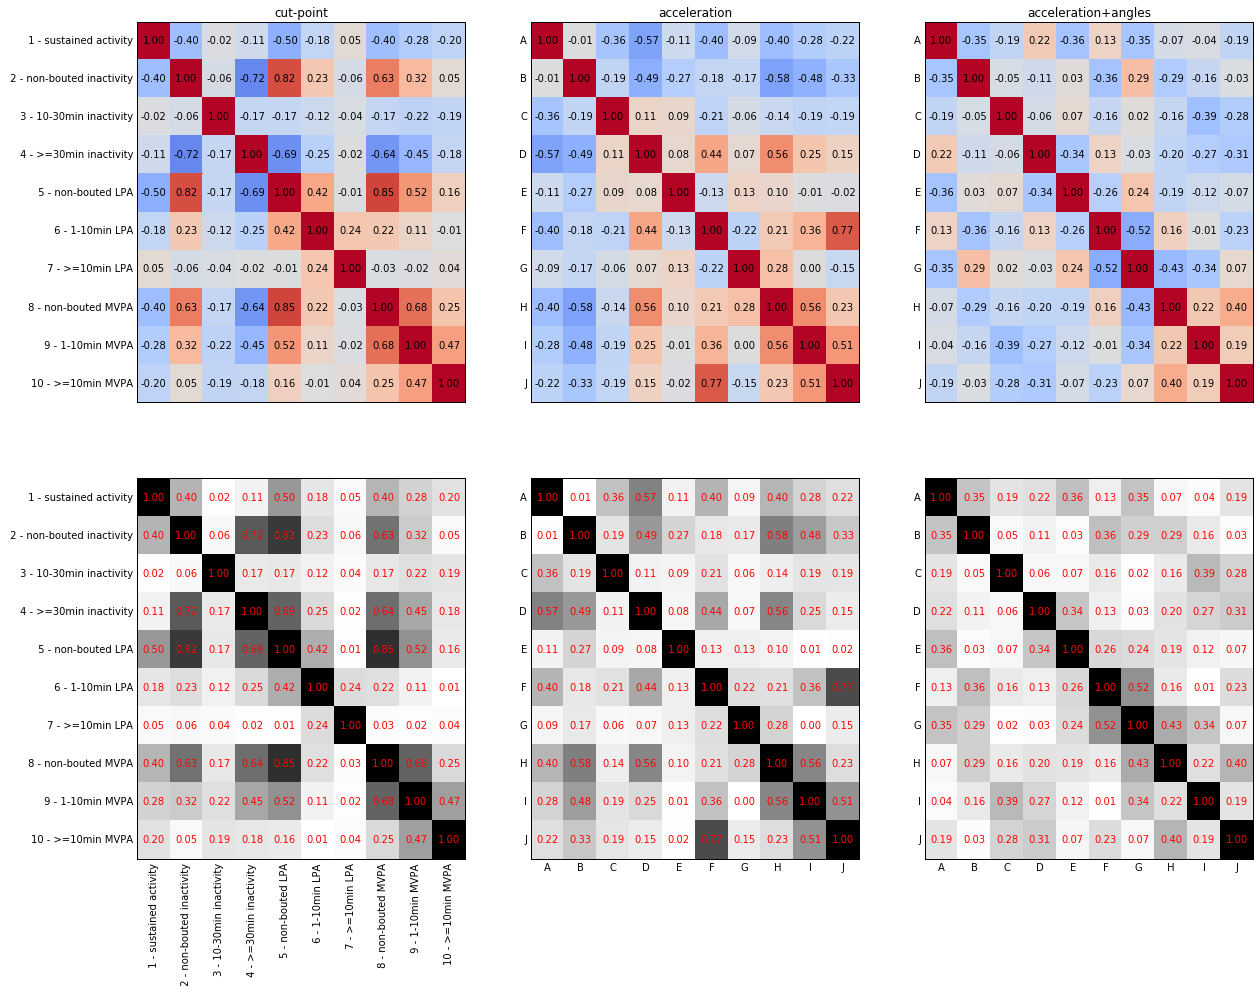

In [61]:
fig, axes = plt.subplots(2,3, figsize=(20,15), sharex='col')
get_pcolorplot(cor_cutoff_df, axes[0,0], values_c='black')
get_pcolorplot(cor_model1_df, axes[0,1], values_c='black')
get_pcolorplot(cor_model2_df, axes[0,2], values_c='black')
get_pcolorplot(np.abs(cor_cutoff_df), axes[1,0], plt.cm.Greys, 0, 1, values_c='red')
get_pcolorplot(np.abs(cor_model1_df), axes[1,1], plt.cm.Greys, 0, 1, values_c='red')
get_pcolorplot(np.abs(cor_model2_df), axes[1,2], plt.cm.Greys, 0, 1, values_c='red')

axes[0,0].set_title('cut-point')
axes[0,1].set_title('acceleration')
axes[0,2].set_title('acceleration+angles')

axes[0,0].set_yticklabels(cor_cutoff_df.columns)
axes[1,0].set_yticklabels(cor_cutoff_df.columns)
axes[1,0].set_xticklabels(cor_cutoff_df.columns, rotation=90)

axes[0,1].set_yticklabels(cor_model1_df.columns)
axes[1,1].set_yticklabels(cor_model1_df.columns)
axes[1,1].set_xticklabels(cor_model1_df.columns)

axes[0,2].set_yticklabels(cor_model2_df.columns)
axes[1,2].set_yticklabels(cor_model2_df.columns)
axes[1,2].set_xticklabels(cor_model2_df.columns)
plt.savefig('correlations_new.png', dpi=300)
plt.show()

In [49]:
os.path.join(config.image_path, 'correlations_new.png')

'/media/sf_VBox_Shared/London/CLSdata500/results/mod_10st_0b_50r_720t_acceleration/images/correlations_new.png'

In [ ]:
mask = np.triu(np.ones(cor_cutoff.shape, dtype=bool), 1)
cor_cutoff_values = cor_cutoff[mask]
cor_model1_values = cor_model1[mask]
cor_model2_values = cor_model2[mask]

print(len(cor_cutoff_values))
print('cutoff: {:.2f}±{:.2f}, min: {:.2f}, max: {:.2f}'.format(np.mean(np.abs(cor_cutoff_values)), np.std(np.abs(cor_cutoff_values)), 
      np.min(np.abs(cor_cutoff_values)),np.max(np.abs(cor_cutoff_values))))
print('acceleration: {:.2f}±{:.2f}, min: {:.2f}, max: {:.2f}'.format(np.mean(np.abs(cor_model1_values)), np.std(np.abs(cor_model1_values)),
                                          np.min(np.abs(cor_model1_values)),np.max(np.abs(cor_model1_values))))
print('acceleration+angles: {:.2f}±{:.2f}, min: {:.2f}, max: {:.2f}'.format(np.mean(np.abs(cor_model2_values)), np.std(np.abs(cor_model2_values)),
                                                 np.min(np.abs(cor_model2_values)),np.max(np.abs(cor_model2_values))))

In [ ]:
print('cutoff: {}'.format(sum(np.abs(cor_cutoff_values)>.5)))
print('acceleration: {}'.format(sum(np.abs(cor_model1_values)>.5)))
print('acceleration+angles: {}'.format(sum(np.abs(cor_model2_values)>.5)))